In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'nearest'
import numpy as np
import matplotlib.pyplot as plt

# Image processing and machine learning

Some image processing numerical techniques are very specific to image processing, such as mathematical morphology or anisotropic diffusion segmentation. However, it is also possible to adapt generic machine learning techniques for image processing.

## A short introduction to machine learning

This section is adapted from the [quick start tutorial](http://scikit-learn.org/stable/tutorial/basic/tutorial.html) from the scikit-learn documentation.

In general, a learning problem considers a set of N samples of data and then tries to predict properties of unknown data. If each sample is more than a single number and, for instance, a multi-dimensional entry (aka multivariate data), it is said to have several attributes or features.

Typical machine learning tasks are :
- **classification**: samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data. For example, given examples of pixels belonging to an object of interest and background, we want the algorithm to label all the other pixels of the image. Or given images of cats and dogs, we want to label automatically images whether they show cats or dogs.
- **clustering**: grouping together similar samples. For example, given a set of pictures, can we group them automatically by suject (e.g. people, monuments, animals...)?

In image processing, a sample can either be
- a whole image, its features being pixel values, or sub-regions of an image (e.g. for face detection)
- a pixel, its features being intensity values in colorspace, or statistical information about a neighbourhood centered on the pixel,
- a labeled region, e.g. for classifying particles in an image of labels

The only requirement is to create a dataset composed of N samples, of m features each, which can be passed to the **estimators** of scikit-learn.

Let us start with an example, using the **digits dataset** from scikit-learn.

In [3]:
from sklearn import datasets

In [4]:
digits = datasets.load_digits()
print(digits)

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'target': array([0, 1, 2, ..., 8, 9, 8]), 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0

The dataset is a dictionary-like object that holds all the data and some metadata about the data. This data is stored in the ``.data`` member, which is a ``n_samples, n_features`` array. Response variables (if available, as here) are stored in the ``.target member.``

In [6]:
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


From the shape of the ``data`` array, we see that there are 1797 samples, each having 64 features. In fact, these 64 pixels are the raveled values of an 8x8 image. For convenience, the 2D images are also provided as in the ``.images`` member. In a machine learning problem, a sample always consists of a **flat array** of features, which sometimes require reshaping data.

In [7]:
print(digits.images.shape)
np.all(digits.data[0].reshape((8, 8)) == digits.images[0])

(1797, 8, 8)


True

target:  0


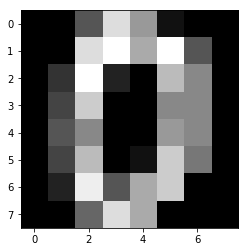

In [8]:
plt.imshow(digits.images[0], cmap='gray')
print("target: ", digits.target[0])

We now use one of scikit-learn's estimators classes in order to predict the digit from an image. 

Here we use an SVC (support vector machine classification) classifier, which uses a part of the dataset (the **training set**) to find the best way to separate the different classes. Even without knowing the details of the SVC, we can use it as a black box thanks to the common estimator API of scikit-learn. An estimator is created by initializing an estimator object: 

In [9]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

The estimator is trained from the learning set using its ``.fit`` method.

In [10]:
clf.fit(digits.data[:-10], digits.target[:-10])

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Then the target value of new data is predicted using the ``.predict`` method of the estimator.

[9 8]


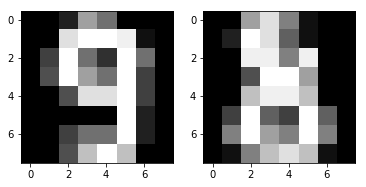

In [11]:
print(clf.predict(digits.data[-2:]))
fig, axes = plt.subplots(1, 2)
axes[0].imshow(digits.images[-2], cmap='gray')
axes[1].imshow(digits.images[-1], cmap='gray')

So far, so good? We completed our first machine learning example!

In the following, we will see how to use machine learning for image processing. We will use different kinds of samples and features, starting from low-level pixel-based features (e.g. RGB color), to mid-level features (e.g. corner, patches of high contrast), and finally to properties of segmented regions. 

**Outline**

- Image segmentation using pixel-based features (color and texture)
- Panorama stitching / image registration based on mid-level features
- Classifying labeled objects using their properties

**What we will not cover** 

- computer vision: automatic detection / recognition of objects (faces, ...)

**A follow-up by Stéfan after this part** : image classification using deep learning with Keras.

## Thresholding and vector quantization

Image binarization is a common operation. For grayscale images, finding the best threshold for binarization can be a manual operation. Alternatively, algorithms can select a threshold value automatically; which is convenient for computer vision, or for batch-processing a series of images.

Otsu algorithm is the most famous thresholding algorithm. It maximizes the variance between the two segmented groups of pixels. Therefore, it is can be interpreted as a **clustering** algorithm. Samples are pixels and have a single feature, which is their grayscale value.

In [12]:
from skimage import data, exposure, filters
camera = data.camera()

In [13]:
hi = exposure.histogram(camera)

In [14]:
val = filters.threshold_otsu(camera)

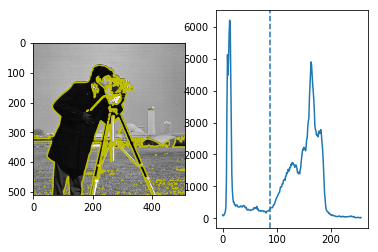

In [15]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(camera, cmap='gray')
axes[0].contour(camera, [val], colors='y')
axes[1].plot(hi[1], hi[0])
axes[1].axvline(val, ls='--')

How can we transpose the idea of Otsu thresholding to RGB or multichannel images? We can use the k-means algorithm, which aims to partition samples in k clusters, where each sample belongs to the cluster of nearest mean. 

Below we show a simple example of k-means clustering, based on the Iris dataset of ``scikit-learn``. Note that the ``KMeans`` estimator
uses a similar API as the SVC we used for digits classification, with the .fit method.

Text(0.5,0,'Petal length')

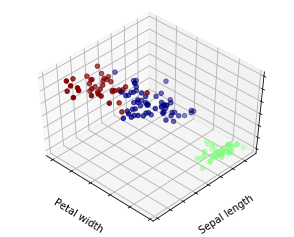

In [16]:
# From http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

clf = KMeans(n_clusters=3)
              
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
clf.fit(X)
labels = clf.labels_

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), cmap='jet')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

k-means clustering uses the Euclidean distance in feature space to cluster samples. If we want to cluster together pixels of similar color, the RGB space is not well suited since it mixes together information about color and light intensity. Therefore, we first transform the RGB image into [Lab colorspace](https://en.wikipedia.org/wiki/Lab_color_space), and only use the color channels (a and b) for clustering.

In [17]:
from skimage import io, color
im = io.imread('../images/round_pill.jpg')

In [18]:
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 1].ravel(), im_lab[..., 2].ravel()])

Then we create a ``KMeans`` estimator for two clusters.

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

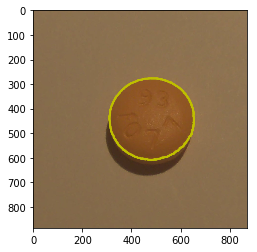

In [20]:
plt.imshow(im)
plt.contour(segmentation, colors='y')

Of course we can generalize this method to more than two clusters.

In [21]:
im = io.imread('../images/chapel_floor.png')
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 0].ravel(),
                 im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=4, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

(-0.5, 375.5, 276.5, -0.5)

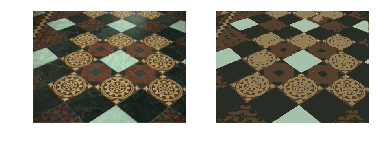

In [22]:
color_mean = color.label2rgb(segmentation, im, kind='mean')
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[0].axis('off')
axes[1].imshow(color_mean)
axes[1].axis('off')

### Exercise:

For the chapel floor image, cluster the image in 3 clusters, using only the color channels (not the lightness one). What happens?

## SLIC algorithm: clustering using color and spatial features

In the thresholding / vector quantization approach presented above, pixels are characterized only by their color features. However, in most images neighboring pixels correspond to the same object. Hence, information on spatial proximity between pixels can be used in addition to color information.

SLIC (Simple Linear Iterative Clustering) is a segmentation algorithm which clusters pixels in both space and color. Therefore, regions of space that are similar in color will end up in the same segment.

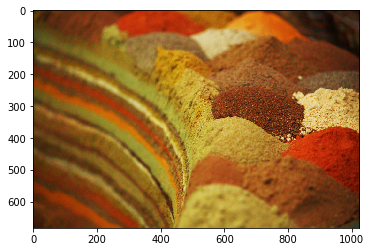

In [23]:
spices = io.imread('../images/spices.jpg')
plt.imshow(spices)

Let us try to segment the different spices using the previous k-means approach. One problem is that there is a lot of texture coming from the relief and shades.

In [ ]:
im_lab = color.rgb2lab(spices)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=10, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(color_mean)

In [ ]:
from skimage import segmentation
plt.imshow(segmentation.mark_boundaries(spices, labels))

SLIC is a superpixel algorithm, which segments an image into patches (superpixels) of neighboring pixels with a similar color. SLIC also works in the Lab colorspace. The ``compactness`` parameter controls the relative importance of the distance in image- and color-space.

In [ ]:
from skimage import segmentation
segments = segmentation.slic(spices, n_segments=200, compactness=20)

In [ ]:
plt.imshow(segmentation.mark_boundaries(spices, segments))

In [ ]:
result = color.label2rgb(segments, spices, kind='mean')
plt.imshow(result)

After the super-pixel segmentation (which is also called oversegmentation, because we end up with more segments that we want to), we can add a second clustering step to join superpixels belonging to the same spice heap.

In [ ]:
im_lab = color.rgb2lab(result)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=5, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(segmentation.mark_boundaries(spices, labels))

Note that other superpixel algorithms are available, such as **Felzenswalb** segmentation.

In [ ]:
result = segmentation.felzenszwalb(spices, scale=100)
plt.imshow(color.label2rgb(result, spices, kind='mean'))

In [ ]:
plt.imshow(segmentation.mark_boundaries(spices, result))

### Exercise

Repeat the same operations (SLIC superpixel segmentation, followed by K-Means clustering on the average color of superpixels) on the astronaut image. Vary the following parameters
- slic: n_segments and compactness
- KMeans: n_clusters (start with 8 for example)

In [ ]:
from skimage import data
astro = data.astronaut()

In [ ]:
# solution goes here

## Increasing the number of low-level features: trained segmentation using Gabor filters and random forests

In the examples above, a small number of features per pixel was used: either a color triplet only, or a color triplet and its (x, y) position. However, it is possible to use other features, such as the local texture. Texture features can be obtained using Gabor filters, which are Gaussian kernels modulated by a sinusoidal wave. 

In [ ]:
# From http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html
from skimage import data, img_as_float
from skimage.filters import gabor_kernel
import scipy.ndimage as ndi

shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for frequency in (0.1, 0.4):
    kernel = gabor_kernel(frequency, theta=0)
    params = 'frequency=%.2f' % (frequency)
    kernel_params.append(params)
    # Save kernel and the power image for each image
    results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(5, 4))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

We define a segmentation algorithms which:
- computes different features for Gabor filters of different scale and angle, for every pixel
- trains a **RandomForest** classifier from user-labeled data, which are given as a mask of labels
- and predicts the label of the remaining non-labeled pixels

The RandomForest algorithm chooses automatically thresholds along the different feature directions, and also decides which features are the most significant to discriminate between the different classes. This is very useful when we don't know if all features are relevant.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from skimage import filters
from skimage import img_as_float

def _compute_features(im):
    gabor_frequencies = np.logspace(-3, 1, num=5, base=2)
    thetas = [0, np.pi/2]
    nb_fq = len(gabor_frequencies) * len(thetas)
    im = np.atleast_3d(im)
    im_gabor = np.empty((im.shape[-1], nb_fq) + im.shape[:2])
    for ch in range(im.shape[-1]):
        img = img_as_float(im[..., ch])
        for i_fq, fq in enumerate(gabor_frequencies):
            for i_th, theta in enumerate(thetas):
                tmp = filters.gabor(img, fq, theta=theta)
                im_gabor[ch, len(thetas) * i_fq + i_th] = \
                                    np.abs(tmp[0] + 1j * tmp[1])
    return im_gabor


def trainable_segmentation(im, mask):
    """
    Parameters
    ----------
    
    im : ndarray
        2-D image (grayscale or RGB) to be segmented
        
    mask : ndarray of ints
        Array of labels. Non-zero labels are known regions that are used
        to train the classification algorithm.
    """
    # Define features
    im_gabor = _compute_features(im)     
    nb_ch, nb_fq, sh_1, sh2 = im_gabor.shape
    # Training data correspond to pixels labeled in mask
    training_data = im_gabor[:, :, mask>0]
    training_data = training_data.reshape((nb_ch * nb_fq,
                                         (mask>0).sum())).T
    training_labels = mask[mask>0].ravel()
    # Data are from the remaining pixels
    data = im_gabor[:, :, mask == 0].reshape((nb_ch * nb_fq,
                                              (mask == 0).sum())).T
    # classification
    clf = RandomForestClassifier()
    clf.fit(training_data, training_labels)
    labels = clf.predict(data)
    result = np.copy(mask)
    result[mask == 0] = labels
    return result

In [ ]:
# Image from https://fr.wikipedia.org/wiki/Fichier:Bells-Beach-View.jpg
beach = io.imread('../images/Bells-Beach.jpg')

In [ ]:
# Define mask of user-labeled pixels, which will be used for training
mask = np.zeros(beach.shape[:-1], dtype=np.uint8)
mask[700:] = 1
mask[:550, :650] = 2
mask[400:450, 1000:1100] = 3
plt.imshow(beach)
plt.contour(mask, colors='y')

In [ ]:
result = trainable_segmentation(beach, mask)
plt.imshow(color.label2rgb(result, beach, kind='mean'))

## Using mid-level features 



In [ ]:
from skimage import data
camera = data.camera()
from skimage import feature
corner_camera = feature.corner_harris(camera)
coords = feature.corner_peaks(corner_camera)
plt.imshow(camera, cmap='gray')
plt.plot(coords[:, 1], coords[:, 0], 'o')
plt.xlim(0, 512)
plt.ylim(512, 0)

[Panorama stitching](example_pano.ipynb)

[A longer example](adv3_panorama-stitching.ipynb)

### Exercise

Represent the ORB keypoint of the camera-man

In [ ]:
# solution goes here

## Clustering or classifying labeled objects

We have already seen how to use ``skimage.measure.regionprops`` to extract the properties (area, perimeter, ...) of labeled objects. These properties can be used as features in order to cluster the objects in different groups, or to classify them if given a training set.

In the example below, we use ``skimage.data.binary_blobs`` to generate a binary image. We use several properties to generate features: the area, the ratio between squared perimeter and area, and the solidity (which is the area fraction of the object as compared to its convex hull). We would like to separate the big convoluted particles from the smaller round ones. Here I did not want to bother with a training set, so we will juste use clustering instead of classifying.

In [ ]:
from skimage import measure
from skimage import data
im = data.binary_blobs(length=1024, blob_size_fraction=0.05,
                         volume_fraction=0.2)
labels = measure.label(im)
props = measure.regionprops(labels)

data = np.array([(prop.area,
                  prop.perimeter**2/prop.area,
                  prop.solidity) for prop in props])

In [ ]:
plt.imshow(labels, cmap='spectral')

Once again we use the KMeans algorithm to cluster the objects. We visualize the result as an array of labels.

In [ ]:
clf = KMeans(n_clusters=2)

clf.fit(data)


def reshape_cluster_labels(cluster_labels, image_labels):
    """
    Some NumPy magic
    """
    cluster_labels = np.concatenate(([0], cluster_labels + 1))
    return cluster_labels[image_labels]
    

object_clusters = reshape_cluster_labels(clf.labels_, labels)
plt.imshow(object_clusters, cmap='spectral')

However, our features were not carefully designed. Since the ``area`` property can take much larger values than the other properties, it dominates the other ones. To correct this effect, we can normalize the area to its maximal value. 

In [ ]:
data[:, 0] /= data[:, 0].max()

clf.fit(data)

object_clusters = reshape_cluster_labels(clf.labels_, labels)
plt.imshow(object_clusters, cmap='spectral')


A better way to do the rescaling is to use of the scaling methods provided by ``sklearn.preprocessing``. The ``StandardScaler`` makes sure that every feature has a zero mean and a unit standard deviation.

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()
data_scaled = min_max_scaler.fit_transform(data)

clf = KMeans(n_clusters=2)

clf.fit(data_scaled)

object_clusters = reshape_cluster_labels(clf.labels_, labels)
plt.imshow(object_clusters, cmap='spectral')

###Exercise

Replace the area property by the eccentricity, so that clustering separates compact and convoluted particles, regardless of their size. 